Convolutional Neural Networks (CNNs)
Convolutional neural networks are a class of deep learning models designed to process data that has a grid-like structure, such as images (2D grids of pixels) or time–frequency representations of signals.

Core idea
A CNN learns filters (also called kernels) that are convolved with the input to detect local patterns like edges, textures, or shapes. Stacking many convolutional layers allows the network to build up a hierarchy of features, from simple to highly abstract.

Main building blocks
Convolutional layers: Apply learnable filters that slide across the input and compute dot products.

Non‑linear activations: Functions such as ReLU introduce non‑linearity, enabling the network to model complex relationships.

Pooling layers: Downsample feature maps (for example with max‑pooling) to gain translation invariance and reduce dimensionality.

Fully connected layers: Operate on the high‑level features at the end of the network to perform tasks such as classification.

Normalization and regularization: Layers like batch normalization and dropout help stabilize training and reduce overfitting.

Epoch 01: train_acc=0.951, val_acc=1.000
Epoch 02: train_acc=1.000, val_acc=1.000
Epoch 03: train_acc=1.000, val_acc=1.000
Epoch 04: train_acc=1.000, val_acc=1.000
Epoch 05: train_acc=1.000, val_acc=1.000
Epoch 06: train_acc=1.000, val_acc=1.000
Epoch 07: train_acc=1.000, val_acc=1.000
Epoch 08: train_acc=1.000, val_acc=1.000
Epoch 09: train_acc=1.000, val_acc=1.000
Epoch 10: train_acc=1.000, val_acc=1.000


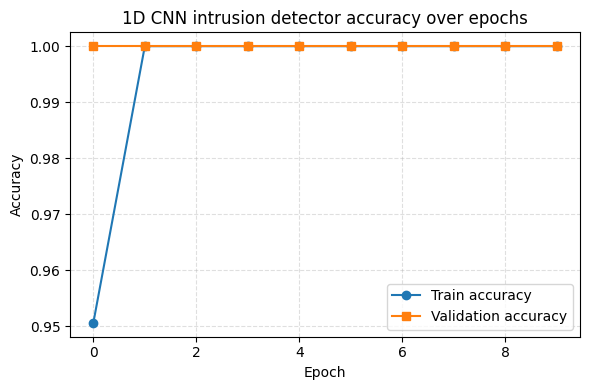

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# =========================
# 1. Synthetic data creation
# =========================

np.random.seed(42)
num_samples = 2000
num_features = 20

# Benign traffic (class 0): lower means, smaller variance
benign_mean = 10.0
benign_std = 3.0
num_benign = num_samples // 2
benign_data = np.random.normal(
    loc=benign_mean,
    scale=benign_std,
    size=(num_benign, num_features),
)

# Malicious traffic (class 1): higher means, larger variance, bursts
malicious_mean = 18.0
malicious_std = 5.0
num_malicious = num_samples - num_benign
malicious_data = np.random.normal(
    loc=malicious_mean,
    scale=malicious_std,
    size=(num_malicious, num_features),
)

# Stack features and labels
X = np.vstack([benign_data, malicious_data]).astype("float32")
y = np.hstack([
    np.zeros(num_benign, dtype="int64"),  # class 0
    np.ones(num_malicious, dtype="int64"),  # class 1
])

# =========================
# 2. Normalization and split
# =========================

# Feature normalization (per feature)
X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True) + 1e-6
X = (X - X_mean) / X_std

# Shuffle and split into train/validation
indices = np.arange(num_samples)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

split = int(0.8 * num_samples)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Convert to PyTorch tensors, shape: (N, C, L) for Conv1d
X_train_t = torch.tensor(X_train).unsqueeze(1)  # (N, 1, 20)
X_val_t = torch.tensor(X_val).unsqueeze(1)
y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# =========================
# 3. CNN model definition
# =========================

class Net1DCNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Input: (batch, 1, num_features)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 classes: benign, malicious
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))   # (batch, 32, L)
        x = self.pool(x)               # (batch, 32, L/2)
        x = self.relu(self.conv2(x))   # (batch, 64, L/2)
        x = self.global_pool(x)        # (batch, 64, 1)
        x = x.squeeze(-1)              # (batch, 64)
        x = self.relu(self.fc1(x))     # (batch, 64)
        x = self.fc2(x)                # (batch, 2 logits)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net1DCNN(num_features=num_features).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# =========================
# 4. Training loop + metrics
# =========================

num_epochs = 10
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_correct = 0
    total_examples = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_examples += xb.size(0)

    train_acc = total_correct / total_examples
    train_acc_history.append(train_acc)

    # ---- Validation ----
    model.eval()
    val_correct = 0
    val_examples = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            val_examples += xb.size(0)

    val_acc = val_correct / val_examples
    val_acc_history.append(val_acc)

    print(
        f"Epoch {epoch + 1:02d}: "
        f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}"
    )

# =========================
# 5. Visual proof: accuracy plot
# =========================

plt.figure(figsize=(6, 4))
plt.plot(train_acc_history, label="Train accuracy", marker="o")
plt.plot(val_acc_history, label="Validation accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("1D CNN intrusion detector accuracy over epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("cnn_intrusion_accuracy.png", dpi=150)
plt.show()


That PyTorch code trains a 1D CNN to distinguish benign vs. malicious synthetic network flows.
The code creates synthetic “network flows”:

2,000 samples, each with 20 numeric features (you can interpret them as counts, timings, flags).

Half are labeled 0 (benign) with lower mean/variance, half 1 (malicious) with higher/burstier stats.

Normalizes features so each feature is roughly zero‑mean, unit‑variance.

Splits into train/validation sets (80%/20%).

Builds a 1D CNN:

Input shape:
1
×
20
1×20 per flow.

Conv1d → ReLU → MaxPool → Conv1d → Global Max Pool → Dense → Dense(2 logits).

Uses CrossEntropyLoss, which internally applies softmax to logits.

Trains for 10 epochs with Adam:

In each epoch it:

Runs forward pass on each batch.

Computes loss and gradients.

Updates weights.

Tracks training loss/accuracy and validation accuracy.

Prints a line like: Epoch 01: train_loss=..., train_acc=..., val_acc=....

So you do get textual evidence that the CNN is learning (validation accuracy), but no charts yet.